# Empirical Cross Covariance

Note that the analysis below assumes realizations are independent across time. This is a bad assumption, but should still provide a reasonable approximation.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "../src")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import variogram as vgm

In [4]:
# Analysis variables
year = 2019
tol = 500
time_lag = 1

In [5]:
# Get data: detrended 5-degree monthly average, cont. US
df = pd.read_csv("../data/exp_pro/OCO2_5deg_monthly_conus.csv")

# Isolate year
df["time"] = pd.to_datetime(df["time"])
df = df[df.time.dt.year == year]

# Standardize data locally
columns = ["xco2_res", "sif_res"]
df[columns] = df.groupby(["lon", "lat"])[columns].transform(lambda x: (x - x.mean()) / x.std())

df.head()

,lat,lon,time,sif_res,xco2_res
52,12.5,-92.5,2019-01-01,-0.542864,-0.165133
53,12.5,-92.5,2019-02-01,-1.047602,0.325714
54,12.5,-92.5,2019-03-01,-1.555631,0.840372
55,12.5,-92.5,2019-04-01,-0.168187,1.615102
56,12.5,-92.5,2019-05-01,0.235828,1.042413


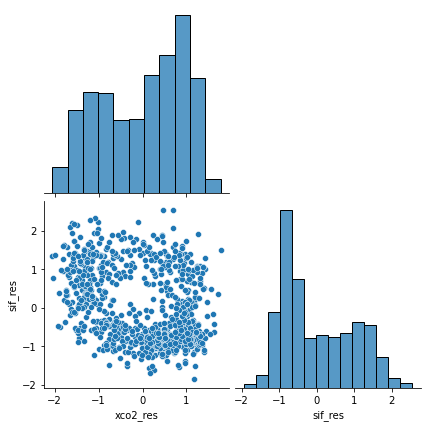

In [6]:
# Check distributions
p = sns.pairplot(df, vars=["xco2_res", "sif_res"], corner=True, height=3)
p.savefig(f"../plots/pairplot_{year}.png")

In [7]:
# Compute empirical variograms and cross covariogram
space_lags = np.linspace(0, 5e3, 50)

df_vgm = vgm.empirical_variogram(
    df,
    ["xco2_res", "sif_res"],
    space_lags,
    tol=tol,
    time_lag=0,
    cross=False,
)
df_cov = vgm.empirical_variogram(
    df,
    ["xco2_res", "sif_res"],
    space_lags,
    tol=tol,
    time_lag=time_lag,
    covariogram=True,
)

In [23]:
# Fit the theoretical Matern covariance model
vgm_guess = [0.4, 4e3, 0.1]
cross_guess = [0.25, 0.25, 4e3, 0.0]

xco2_params, df_vgm["xco2_fit"] = vgm.fit_variogram(df_vgm["lag"], df_vgm["xco2_res"], vgm_guess)
sif_params, df_vgm["sif_fit"] = vgm.fit_variogram(df_vgm["lag"], df_vgm["sif_res"], vgm_guess)
cross_params, df_cov["cross_fit"] = vgm.fit_variogram(df_cov["lag"], df_cov["xco2_res:sif_res"], cross_guess, cross=True)

`ftol` termination condition is satisfied.
Function evaluations 13, initial cost 1.1309e+00, final cost 1.5360e-02, first-order optimality 2.60e-06.
`ftol` termination condition is satisfied.
Function evaluations 27, initial cost 1.1365e+01, final cost 1.8729e-01, first-order optimality 1.34e-05.
`ftol` termination condition is satisfied.
Function evaluations 26, initial cost 1.1140e+00, final cost 4.1995e-03, first-order optimality 5.76e-06.


In [31]:
def param_labels(params, cross=False):
    p = np.round_(params, decimals=3)
    if cross:
        return f"sigma1: {p[0]}\n sigma2: {p[1]}\n nu: 2.5\n len_scale: {p[2]}\n rho: {p[3]}"
    else:
        return f"sigma_squared: {p[0]}\n nu: 2.5\n len_scale: {p[1]}\n nugget: {p[2]}"

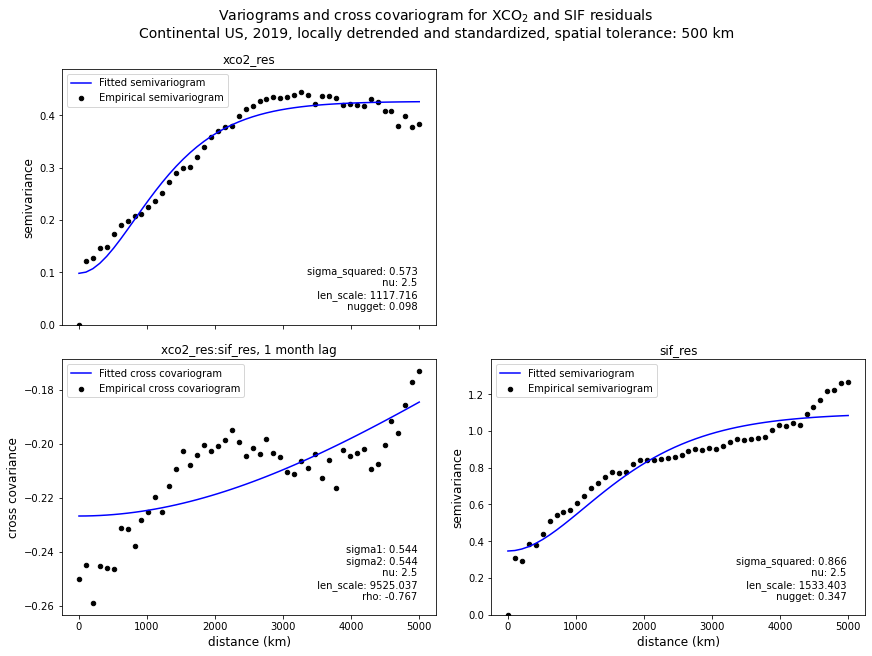

In [30]:
cols = df_cov.columns[df_cov.columns!="lag"]
fig, ax = plt.subplots(2, 2, figsize=(12, 9), constrained_layout=True, sharex=True)
ax[0, 1].axis("off")

df_vgm.plot(x="lag", y="xco2_res", kind="scatter", color="black", ax=ax[0, 0], label="Empirical semivariogram")
df_vgm.plot(x="lag", y="xco2_fit", kind="line", color="blue", ax=ax[0, 0], label="Fitted semivariogram")
lim = df_vgm["xco2_res"].max()
ax[0, 0].set_title(cols[0], fontsize=12)
ax[0, 0].set_ylabel("semivariance", fontsize=12)
ax[0, 0].set_ylim([0, lim+0.1*lim])
ax[0, 0].text(0.95, 0.05, param_labels(xco2_params), transform=ax[0, 0].transAxes, ha="right", va="bottom")
ax[0, 0].legend()

df_vgm.plot(x="lag", y="sif_res", kind="scatter", color="black", ax=ax[1, 1], label="Empirical semivariogram")
df_vgm.plot(x="lag", y="sif_fit", kind="line", color="blue", ax=ax[1, 1], label="Fitted semivariogram")
lim = df_vgm["sif_res"].max()
ax[1, 1].set_title(cols[1], fontsize=12)
ax[1, 1].set_ylabel("semivariance", fontsize=12)
ax[1, 1].set_xlabel("distance (km)", fontsize=12)
ax[1, 1].set_ylim([0, lim+0.1*lim])
ax[1, 1].text(0.95, 0.05, param_labels(sif_params), transform=ax[1, 1].transAxes, ha="right", va="bottom")
ax[1, 1].legend()

df_cov.plot(x="lag", y="xco2_res:sif_res", kind="scatter", color="black", ax=ax[1, 0], label="Empirical cross covariogram")
df_cov.plot(x="lag", y="cross_fit", kind="line", color="blue", ax=ax[1, 0], label="Fitted cross covariogram")
ax[1, 0].set_title("xco2_res:sif_res" + f", {time_lag} month lag", fontsize=12)
ax[1, 0].set_ylabel("cross covariance", fontsize=12)
ax[1, 0].set_xlabel("distance (km)", fontsize=12)
ax[1, 0].text(0.95, 0.05, param_labels(cross_params, cross=True), transform=ax[1, 0].transAxes, ha="right", va="bottom")
ax[1, 0].legend()

fig.suptitle("Variograms and cross covariogram for XCO$_2$ and SIF residuals\n"+
             f"Continental US, {year}, locally detrended and standardized, spatial tolerance: {tol} km", fontsize=14)

fig.savefig(f"../plots/vario_analysis_conUS_{year}_{time_lag}M_{tol}km.png", dpi=100)